Our formalism generalizes trivially to cross-correlations. In this notebook, we explain how to:
- cross-correlate two sets of $a_{\ell m}$s obtained directly from catalogs
- cross-correlate a pixelized map with an $a_{\ell m}$ set obtained once again directly from a catalog.

To explain the mechanics in more details, let's consider a "lognormal catalog" and impose a "survey footprint" covering a fraction of the sky defined by intervals in $\cos\theta$ and $\phi$ with small "veto" regions.

See the [lognormal catalog notebook](lognormal_catalog.ipynb) for more details of the mock catalog and the cells below for the mask.

(This notebook does a smaller version of the example shown in the paper, which was run on a dedicated compute node rather than a shared notebook server.  The current settings are reasonable for the JAX implementation, but smaller problem sizes will lead to more "real-time" execution in the Python/numpy version.)

In [1]:
import numpy  as np
import healpy as hp
import sys
#
import matplotlib.pyplot as plt

In [2]:
%env JAX_ENABLE_X64=True
#
from sht.sht                import DirectSHT
from sht.mocks              import LogNormalMocks
from sht.mask_deconvolution import MaskDeconvolution

env: JAX_ENABLE_X64=True


In [3]:
# Get a random number generator.
seed = None
rng  = np.random.default_rng(seed)

## Generate two mock catalogs and their randoms

For each sample we wish to cross-correlate, we generate two points sets: the data catalog (from a lognormal model) and the random catalog that implicitly defines the mask, the window function, etc.

In [4]:
# Define our footprint by intervals in cos(theta) and phi.
cthta_min_1 = -0.4
cthta_max_1 =  0.5
theta_min_1 =  np.arccos(cthta_max_1)
theta_max_1 =  np.arccos(cthta_min_1)
phi_min_1   =  0.2
phi_max_1   =  5.0
#
print("Sky fraction for the first sample {:f}".format( (phi_max_1-phi_min_1)*(cthta_max_1-cthta_min_1)/(4*np.pi) ))

# And similarly for the second sample
cthta_min_2 = -0.3
cthta_max_2 =  0.6
theta_min_2 =  np.arccos(cthta_max_2)
theta_max_2 =  np.arccos(cthta_min_2)
phi_min_2   =  0.25
phi_max_2   =  4.5
#
print("Sky fraction for the second sample {:f}".format( (phi_max_2-phi_min_2)*(cthta_max_2-cthta_min_2)/(4*np.pi) ))

Sky fraction for the first sample 0.343775
Sky fraction for the second sample 0.304384


In [5]:
# To put more structure in the masks, let's "cut out" various pieces of the
# sky, vetoing both data and random points.
# Generate a random catalog of "veto centers" and "radii".
nveto_1 = 10
tveto_1 = np.arccos( rng.uniform(low=cthta_min_1,high=cthta_max_1,size=nveto_1) )
pveto_1 = rng.uniform(low=phi_min_1,high=phi_max_1,size=nveto_1)
rveto_1 = np.ones_like(tveto_1) * 0.999
# and convert these into 3D unit vectors
nveto_1 = np.zeros( (nveto_1,3) )
nveto_1[:,0] = np.sin(tveto_1)*np.cos(pveto_1)
nveto_1[:,1] = np.sin(tveto_1)*np.sin(pveto_1)
nveto_1[:,2] = np.cos(tveto_1)

# Similarly for the second sample
nveto_2 = 10
tveto_2 = np.arccos( rng.uniform(low=cthta_min_2,high=cthta_max_2,size=nveto_2) )
pveto_2 = rng.uniform(low=phi_min_2,high=phi_max_2,size=nveto_2)
rveto_2 = np.ones_like(tveto_2) * 0.999
# and convert these into 3D unit vectors
nveto_2 = np.zeros( (nveto_2,3) )
nveto_2[:,0] = np.sin(tveto_2)*np.cos(pveto_2)
nveto_2[:,1] = np.sin(tveto_2)*np.sin(pveto_2)
nveto_2[:,2] = np.cos(tveto_2)

In [6]:
def veto_points(tt,pp,wt,nveto,rveto):
    """Returns 'trimmed' tt, pp, wt arrays vetoed by a set of 'veto' points."""
    nh      = np.zeros( (tt.size,3) )
    nh[:,0] = np.sin(tt)*np.cos(pp)
    nh[:,1] = np.sin(tt)*np.sin(pp)
    nh[:,2] = np.cos(tt)
    ww      = np.ones(tt.size,dtype='bool')
    for i in range(nveto.shape[0]):
        ww &= np.dot(nh,nveto[i,:])<rveto[i]
    return( (tt[ww],pp[ww],wt[ww]) )

In [7]:
# Generate a lognormal mock
npnt_fullsky = 3 * 500000
#
# Initialize a helper object from which to draw realizations
nside_mockmaking = 8192 # As large as possible.
Mocks_obj_1 = LogNormalMocks(npnt_fullsky,nside=nside_mockmaking, 
                           theta_range=[theta_min_1,theta_max_1],
                           phi_range=[phi_min_1,phi_max_1])
#
print('Npnt/Npix=', npnt_fullsky/hp.nside2npix(nside_mockmaking))
# Draw a realization, specifying the random seed if you want
tdata_1,pdata_1,wdata_1 = Mocks_obj_1(seed=0)
ndata_1 = len(tdata_1)

# Do it for the second sample with the same seed
Mocks_obj_2 = LogNormalMocks(npnt_fullsky,nside=nside_mockmaking, 
                           theta_range=[theta_min_2,theta_max_2],
                           phi_range=[phi_min_2,phi_max_2])

# Draw a realization, specifying the random seed if you want
tdata_2,pdata_2,wdata_2 = Mocks_obj_2(seed=0)

#
ndata_2 = len(tdata_2)
print("Kept {:d} objects first in cut.".format(ndata_1))
print("Kept {:d} objects second in cut.".format(ndata_2))

Npnt/Npix= 0.001862645149230957
gmap in range (-3.979337e+00,3.798165e+00)
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 4.447854e-05, maxprob=1.984597e-03
gmap in range (-3.979337e+00,3.798165e+00)
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, maxprob=6.335677e-03
scaling factor 1.419944e-04, max

In [8]:
# Since our two fields are actually the same realization (note the equal seed in the cell above)
# masked different ways, the cross-spectrum is equal to the auto
cl_theory = Mocks_obj_1.get_theory_Cl(lmax_out=1000,gauss_order=3000)

In [9]:
# Code to generate a random catalog.
def generate_randoms(nrand, cthta_min, cthta_max, phi_min, phi_max, ndata):
    """Generate nrand randoms in our footprint."""
    trand = np.arccos( rng.uniform(low=cthta_min,high=cthta_max,size=nrand) )
    prand = rng.uniform(low=phi_min,high=phi_max,size=nrand)
    wrand = np.ones_like(trand) * float(ndata)/float(nrand)
    return( (trand,prand,wrand) )

In [10]:
# Generate the randoms.
nrand_1 = 30*ndata_1
nrand_2 = 30*ndata_2
trand_1,prand_1,wrand_1 = generate_randoms(nrand_1, cthta_min_1, cthta_max_1, phi_min_1, phi_max_1, ndata_1)
trand_2,prand_2,wrand_2 = generate_randoms(nrand_2, cthta_min_2, cthta_max_2, phi_min_2, phi_max_2, ndata_2)

In [11]:
# Run the data and randoms through the "veto mask".
tdata_1,pdata_1,wdata_1 = veto_points(tdata_1,pdata_1,wdata_1,nveto_1,rveto_1)
trand_2,prand_2,wrand_2 = veto_points(trand_2,prand_2,wrand_2,nveto_2,rveto_2)
# Correct for the veto'd points.
ndata_1  = len(tdata_1)
ndata_2  = len(tdata_2)

nrand_1  = len(trand_1)
nrand_2  = len(trand_2)

wrand_1 *= np.sum(wdata_1)/np.sum(wrand_1)
wrand_2 *= np.sum(wdata_2)/np.sum(wrand_2)

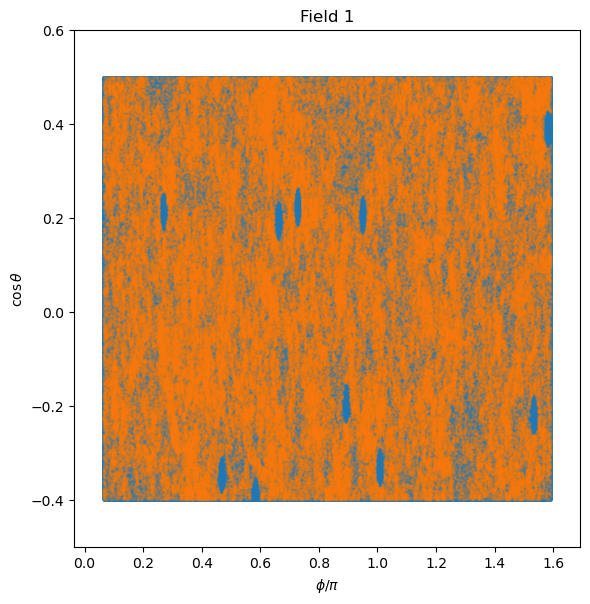

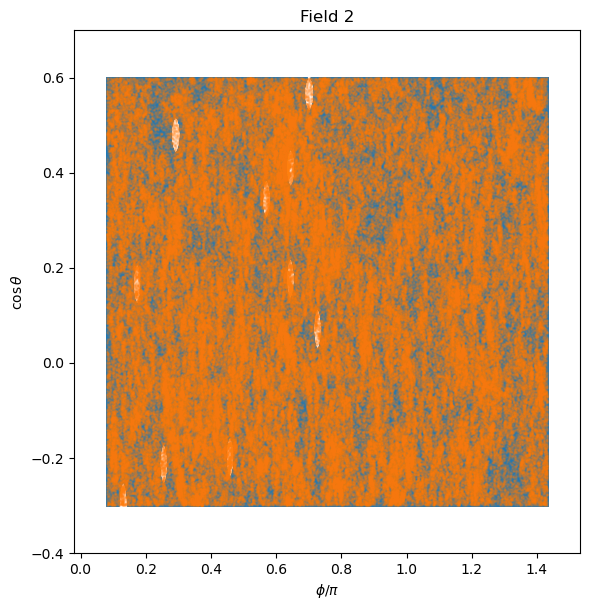

In [12]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
#
ax.scatter(prand_1/np.pi,np.cos(trand_1),s=1,c='C0',alpha=0.1,label='Rand',rasterized=True)
ax.scatter(pdata_1/np.pi,np.cos(tdata_1),s=1,c='C1',alpha=0.1,label='Data',rasterized=True)
#
ax.set_xlim(phi_min_1/np.pi-0.1,phi_max_1/np.pi+0.1)
ax.set_ylim(cthta_min_1-0.1,cthta_max_1+0.1)
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$\cos\theta$')
plt.tight_layout()
plt.title(r'Field 1')
plt.show()

fig,ax = plt.subplots(1,1,figsize=(6,6))
#
ax.scatter(prand_2/np.pi,np.cos(trand_2),s=1,c='C0',alpha=0.1,label='Rand',rasterized=True)
ax.scatter(pdata_2/np.pi,np.cos(tdata_2),s=1,c='C1',alpha=0.1,label='Data',rasterized=True)
#
ax.set_xlim(phi_min_2/np.pi-0.1,phi_max_2/np.pi+0.1)
ax.set_ylim(cthta_min_2-0.1,cthta_max_2+0.1)
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$\cos\theta$')
plt.tight_layout()
plt.title(r'Field 2')
plt.show()

## Harmonic analysis


There are only two differences with the standard case of auto-correlations, really: 
- Replacing the pseudo-$C_{\ell}$ of the mask with $W_{\ell} = \frac{1}{2\ell+1}\sum_{m}|r_{\ell m}|^2 \rightarrow \frac{1}{2\ell+1}\sum_{m} r_{1, \ell m} r^{*}_{2, \ell m}$, possibly subtracting shot noise as before. The calculation of $M_{\ell \ell'}$ then proceeds unchanged.
- Similarly, the pseudo-$C_{\ell}$ of the data-minus-normalized-randoms need to be replaced with $\tilde{C}_{\ell} = \frac{1}{2\ell+1}\sum_{m}|a_{\ell m}- \alpha r_{\ell m}|^2 \rightarrow \frac{1}{2\ell+1}\sum_{m} (a_{1, \ell m} - \alpha_1 r_{1, \ell m}) (a_{2, \ell m}-\alpha_2 r_{2, \ell m})^{*}$, where the $\alpha$s contain the normalization of the randoms.


As with auto-correlations, we first do a "direct harmonic analysis" of the data and random points by applying the SHT, differencing, and then computing the pseudo-spectrum.  We will start by finding the window function from the randoms ...

Let's go to the to the same $\ell_{\rm max}$ in both samples, though this doesn't need to be the case in general -- in some applications, we we will need to truncate the $C_{\ell}$ at the lowest of the two $\ell_{\rm max}$.

In [13]:
# Set up an sht instance.
Nl   = 500
Nx   = 2*Nl
xmax = 0.75
#
sht= DirectSHT(Nl,Nx,xmax)
#
# We'll want to go to higher lmax in W_l to do mode-decoupling
buffer_ells = 64
sht_randoms = DirectSHT(Nl+buffer_ells,Nx,xmax)
#
print("For general, Direct SHT has Nl=",sht.Nell,", Nx=",Nx," and xmax=",xmax)
print("For randoms, Direct SHT has Nl=",sht_randoms.Nell,", Nx=",Nx," and xmax=",xmax)

/global/homes/a/ab2368/.conda/envs/jax-env/lib/python3.11/site-packages/jax/_src/interpreters/mlir.py:711: UserWarning: Some donated buffers were not usable: ShapedArray(float64[125,500,1000]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn(f"Some donated buffers were not usable: {', '.join(unused_donations)}.\n{msg}")
/global/homes/a/ab2368/.conda/envs/jax-env/lib/python3.11/site-packages/jax/_src/interpreters/mlir.py:711: UserWarning: Some donated buffers were not usable: ShapedArray(float64[141,564,1000]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn(f"Some donated buffers were not usable: {', '.join(unused_donations)}.\n{msg}")


For general, Direct SHT has Nl= 500 , Nx= 1000  and xmax= 0.75
For randoms, Direct SHT has Nl= 564 , Nx= 1000  and xmax= 0.75


In [14]:
# Calculate the angular power spectrum of the randoms
#
hran_for_wl_1 = sht_randoms(trand_1,prand_1,wrand_1)
hran_for_wl_2 = sht_randoms(trand_2,prand_2,wrand_2)

#  After subtracting shot noise, this gives us the
#  angular power spectrum of the window function 

# This is a key difference from the case of auto-correlations: note that we take the
# cross-spectrum between the two window alms. The shot noise we level we subtract
# shouldn't matter too much. Here, we just ignore it
sn = 1.0/float(nrand_1)/(4*np.pi) * float(ndata_1)**2
wl = hp.alm2cl(hran_for_wl_1, hran_for_wl_2) #- sn

Sorting & digitizing took  1.9381687641143799  seconds.
Reshaping took  1.4100677967071533  seconds.
Precomputing vs took  2.1902549266815186  seconds.
Computing alm's took  1.7767682075500488  seconds.
Sorting & digitizing took  1.8516120910644531  seconds.
Reshaping took  0.9599604606628418  seconds.
Precomputing vs took  1.5074400901794434  seconds.
Computing alm's took  1.933988332748413  seconds.
Sorting & digitizing took  1.9035239219665527  seconds.
Reshaping took  0.9326386451721191  seconds.
Precomputing vs took  1.5367279052734375  seconds.
Computing alm's took  1.7334825992584229  seconds.
Sorting & digitizing took  2.092296838760376  seconds.
Reshaping took  0.6964414119720459  seconds.
Precomputing vs took  1.0482978820800781  seconds.
Computing alm's took  1.767981767654419  seconds.


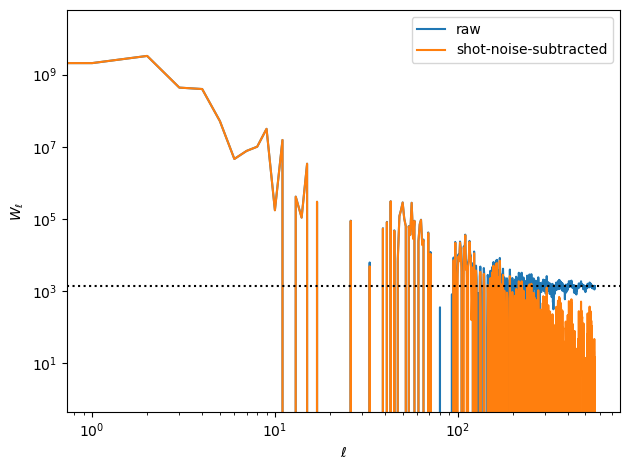

In [15]:
plt.loglog(wl+sn,label='raw')
plt.loglog(wl   ,label='shot-noise-subtracted')
plt.axhline(sn,ls=':',color='k')
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')
plt.legend()
plt.tight_layout()
#plt.savefig('harmonic_window.pdf')

Most of the subsequent steps are exactly as in the standard case of auto-correlations!

In [16]:
# Initialize an instance of the MaskDeconvolution. This will let us deconvolve
# the mask-induced mode-coupling of the pseudo-Cls, convolved the theory to
# enable apples-to-apples comparisons, and provide binning functionality
%time MD = MaskDeconvolution(Nl+buffer_ells,wl)
#
NperBin = 2**5
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# Look at the sums over ell.
print("\nRow sums of Mbl:")
print(Mbl.sum(axis=1))

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...
CPU times: user 2min 26s, sys: 982 ms, total: 2min 27s
Wall time: 2min 30s

Row sums of Mbl:
[0.99998854 0.99999877 1.00000233 0.99999488 1.00000255 0.99999727
 1.00000147 0.99999501 0.99999908 1.00000039 1.00000209 0.99998793
 1.00000269 1.00002257 0.99993741 0.99997197 1.01523471]


Sorting & digitizing took  0.4732017517089844  seconds.
Reshaping took  0.4169654846191406  seconds.
Precomputing vs took  0.7550854682922363  seconds.
Computing alm's took  1.472909688949585  seconds.
Sorting & digitizing took  0.4431943893432617  seconds.
Reshaping took  0.4333653450012207  seconds.
Precomputing vs took  0.6858799457550049  seconds.
Computing alm's took  1.6157317161560059  seconds.
Sorting & digitizing took  0.6790275573730469  seconds.
Reshaping took  0.4717552661895752  seconds.
Precomputing vs took  0.7470889091491699  seconds.
Computing alm's took  1.3467271327972412  seconds.
Sorting & digitizing took  0.5763993263244629  seconds.
Reshaping took  0.4545407295227051  seconds.
Precomputing vs took  0.7731142044067383  seconds.
Computing alm's took  1.365121603012085  seconds.
Sorting & digitizing took  1.3342034816741943  seconds.
Reshaping took  0.510573148727417  seconds.
Precomputing vs took  1.2799265384674072  seconds.
Computing alm's took  0.993194341659545

Text(0, 0.5, '$\\hat{C}_\\ell$')

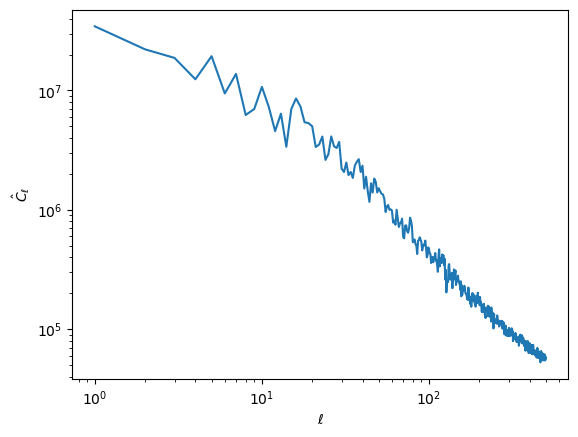

In [17]:
# Get harmonic coefficients for the data and measure raw Cls
hdat_1 = sht(tdata_1,pdata_1,wdata_1)
hdat_2 = sht(tdata_2,pdata_2,wdata_2)
#
# Do the same for the randoms.
hran_1 = sht(trand_1,prand_1,wrand_1)
hran_2 = sht(trand_2,prand_2,wrand_2)
#
# and for the difference of data and randoms: 
# another key difference from the standard case of auto-correlations!
hdif = hp.alm2cl(hdat_1-hran_1, hdat_2-hran_2)
print("hatC in range [{:e},{:e}]".format(np.min(hdif[1:]),np.max(hdif[1:])))
#
plt.loglog(np.arange(1,hdif.size),hdif[1:])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\hat{C}_\ell$')

In [18]:
# Now work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells,hdif_decoupled = MD(hdif,bins)
binned_ells,hdif_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_decoupled[Ndiscard:-Ndiscard]

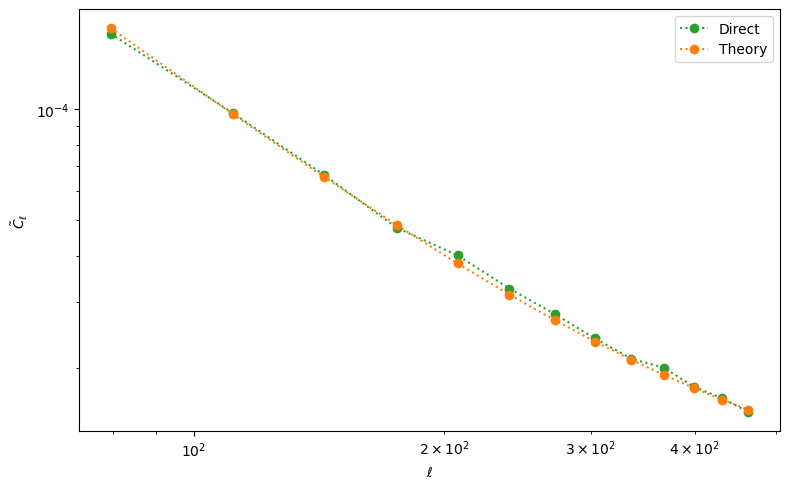

In [19]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')
#
# Compare to the theory convolved with the bandpower window function -- we
# expect some differences due to sample variance, but they shouldn't be huge.
clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
ax.plot(binned_ells, clt_conv[Ndiscard:-Ndiscard],'o:',color='C1',label='Theory')
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\tilde{C}_\ell$')
#
ax.legend()
plt.tight_layout()
#plt.savefig('harmonic_tildeC.pdf')

## Cross-correlating with a pixelized map

Now let's look at the same cross-correlation but in the case where one of the samples is given as pixelized map, while the other is given as $a_{\ell m}$s following the directSHT prescription.

The only changes are:
- Replacing the pseudo-$C_{\ell}$ of the mask with $W_{\ell} =  \frac{1}{2\ell+1}\sum_{m} r_{1, \ell m} r^{*}_{2, \ell m}$, where one of the $r_{i, \ell m}$ comes from the randoms, and the other is obtained from the pixelized map using e.g. `hp.map2clm()`.
- Similarly, the pseudo-$C_{\ell}$ of the data-minus-normalized-randoms need to be replaced with $\tilde{C}_{\ell} =  \frac{1}{2\ell+1}\sum_{m} a_{1, \ell m} (a_{2, \ell m}-\alpha_2 r_{2, \ell m})^{*}$, where $a_{1, \ell m}$ is obtained from the pixelized map (again, using e.g. `hp.map2clm()`) and $a_{2, \ell m}-\alpha_2 r_{2, \ell m}$ is the overdensity of the second field defined a la directSHT/FKP.

Note that throughout all of this, we will only need to take care of one factor of the pixel window function, since the alms provided by directSHT are free of such non-idealities.

To simulate this, let's take the point set #1 and bin it into a map.

In [20]:
def make_map(thetas,phis,wts,nside):
    """Makes a (normalized) Healpix map from the points."""
    pixarea= hp.pixelfunc.nside2pixarea(nside)
    npix   = hp.nside2npix(nside)
    pixnum = hp.ang2pix(nside,thetas,phis)
    dmap,_ = np.histogram(pixnum,bins=np.arange(npix+1)-0.5,weights=wts)
    dmap   = dmap.astype('float64') / pixarea
    return(dmap)

We don't have enough randoms to get a good outcome with a pixel-based analysis, so let's generate more.

In [21]:
# Generate the randoms.
nrand_1 = 70*ndata_1
trand2,prand2,wrand2 = generate_randoms(nrand_1, cthta_min_1, cthta_max_1, phi_min_1, phi_max_1, ndata_1)
# Run the data and randoms through the "veto mask".
trand2,prand2,wrand2 = veto_points(trand2,prand2,wrand2,nveto_1,rveto_1)
# Append the new randoms to the end of the old randoms.
trand  = np.append(trand_1,trand2)
prand  = np.append(prand_1,prand2)
wrand  = np.append(wrand_1,wrand2)
# Redo the weights.
nrand  = len(trand)
wrand *= np.sum(wdata_1)/np.sum(wrand)

dmap.sum= 32443775302.165146
rmap.sum= 32443775302.126755
fsky= 0.3415336608886719


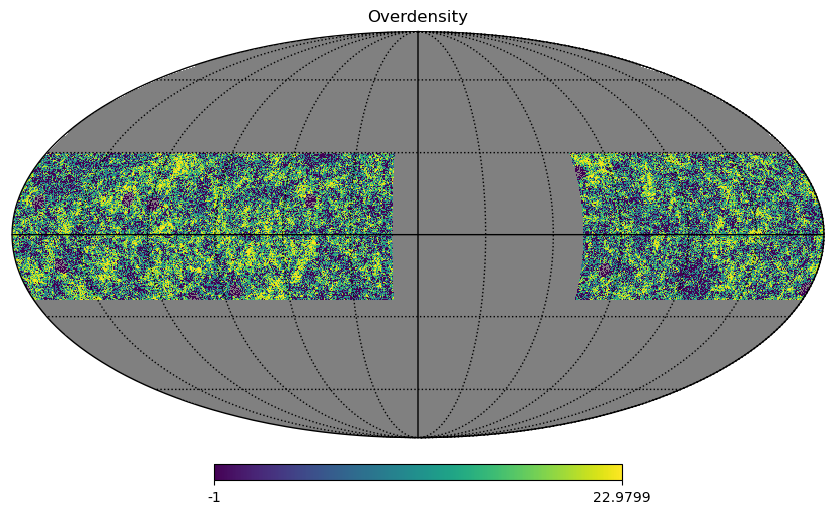

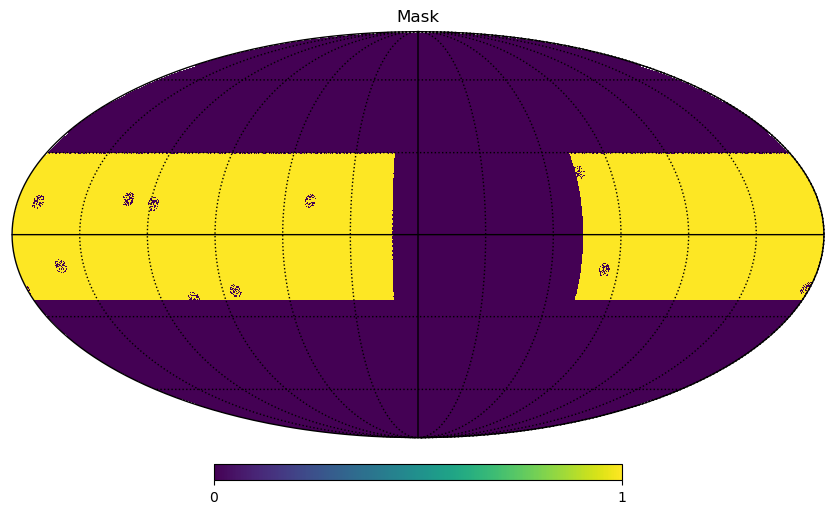

In [22]:
# Show an example at some nside.
nside= 256
npix = hp.nside2npix(nside)
dmap = make_map(tdata_1,pdata_1,wdata_1,nside)
rmap = make_map(trand,prand,wrand,nside)
#
print("dmap.sum=",np.sum(dmap))
print("rmap.sum=",np.sum(rmap))
#
# Remove pixels where we have data but no randoms,
# then generate the 1+delta field.
msk = np.nonzero(rmap>0)[0]
avg = np.mean(rmap[msk])
msk = np.nonzero(rmap>0.5*avg)[0]
#
omap      = np.zeros(npix,dtype='f8')
omap[msk] = dmap[msk]/rmap[msk]
omap[msk] = omap[msk]/np.mean(omap[msk]) - 1
mask      = np.zeros(npix)
mask[msk] = 1.0
#
fsky = len(msk)/float(len(mask))
print("fsky=",fsky)
#
ma = hp.ma(omap)
ma.mask = (mask<0.5)
hp.mollview(ma,norm='hist',title='Overdensity')
hp.graticule()
plt.savefig('overdensity.pdf')
#
hp.mollview(mask,title='Mask')
hp.graticule()

In [23]:
# We get the alms from the pixelized map using the tools of the 
# pixelization of choice
oalm = hp.map2alm(omap, lmax=sht.Nell-1)
# We need to remove the pixel window function from the alms obtained
# from the pixelized map. Note that we do not need to do this for 
# those obtained from directSHT!
pixpin = hp.sphtfunc.pixwin(nside)
hp.sphtfunc.almxfl(oalm, 1./pixpin, inplace=True)

# Get the alms of the mask
mask_alm = hp.map2alm(mask, lmax=sht_randoms.Nell-1)
hp.sphtfunc.almxfl(mask_alm, 1./pixpin, inplace=True)

# Let's ignore shot noise in the window W_l, as its contribution
# is orders of magnitude smaller than the peak of W_l
wl_hybrid = hp.alm2cl(mask_alm, hran_for_wl_2) #- sn

# Finally, take the pseudo-Cls as 
hdif_hybrid = hp.alm2cl(oalm, hdat_2-hran_2)

In [24]:
# Initialize an instance of the MaskDeconvolution. This will let us deconvolve
# the mask-induced mode-coupling of the pseudo-Cls, convolved the theory to
# enable apples-to-apples comparisons, and provide binning functionality
MD = MaskDeconvolution(Nl+buffer_ells,wl_hybrid)
#
NperBin = 2**5
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# Look at the sums over ell.
print("\nRow sums of Mbl:")
print(Mbl.sum(axis=1))

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...

Row sums of Mbl:
[0.99998988 0.99999967 1.00000216 0.99999377 1.00000406 0.99999636
 1.00000213 0.99999657 1.00000136 1.00000151 1.00000218 0.9999879
 1.00000443 1.00002701 0.99993463 0.99997132 1.01543947]


In [25]:
# Now work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells,hdif_hybrid_decoupled = MD(hdif_hybrid,bins)
binned_ells,hdif_hybrid_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_hybrid_decoupled[Ndiscard:-Ndiscard]

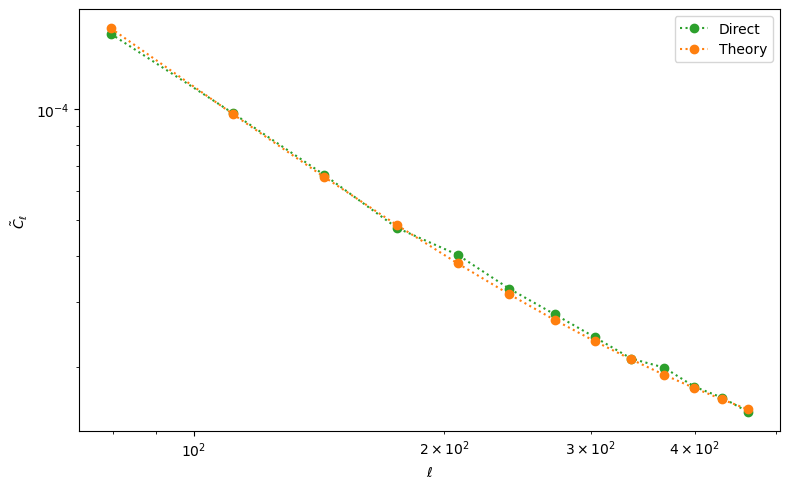

In [26]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,hdif_hybrid_decoupled,'o:',color='C2',label='Direct')
#
# Compare to the theory convolved with the bandpower window function -- we
# expect some differences due to sample variance, but they shouldn't be huge.
clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
ax.plot(binned_ells, clt_conv[Ndiscard:-Ndiscard],'o:',color='C1',label='Theory')
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\tilde{C}_\ell$')
#
ax.legend()
plt.tight_layout()
#plt.savefig('harmonic_tildeC.pdf')